In [133]:
# import packges
import os
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [117]:
info_img=json.load(open('eurosat/rgb/2.0.0/image.image.json'))
info_label=list(open('eurosat/rgb/2.0.0/label.labels.txt','r'))

In [118]:
print(info_img)

{'encoding_format': 'png', 'shape': [64, 64, 3]}


In [119]:
for i in enumerate (info_label):
    print(i[0],i[1])

0 AnnualCrop

1 Forest

2 HerbaceousVegetation

3 Highway

4 Industrial

5 Pasture

6 PermanentCrop

7 Residential

8 River

9 SeaLake



In [120]:
raw_dataset = tf.data.TFRecordDataset("eurosat/rgb/2.0.0/eurosat-train.tfrecord-00000-of-00001")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "SeaLake_2401.jpg"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\000@\000@\003\001\"\000\002\021\001\003\021\001\377\304\000\027\000\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\002\n\377\304\000(\020\

In [121]:
# Define the feature description
feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

In [122]:
feature_description

{'filename': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'image': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}

In [123]:
# Parse the protobuf message
def _parse_function(example_proto):
    #uses tf.io.parse_single_example to parse a single example from a serialized data. 
    #feature_description is assumed to be defined globally 
    #which describes the expected features in the serialized data. 
    return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = raw_dataset.map(_parse_function)



In [124]:
# Create empty lists to store the data
filenames = []
images = []
labels = []
hogs = []
lbps = []
vggs = []

In [125]:

# Define a function to decode the image data
def decode_image(image_data):
    #takes an image image_data in JPEG format and 
    #applies a series of preprocessing steps. 
    #It first decodes the JPEG image into a 3D tensor of shape [height, width, channels] 
    #using tf.image.decode_jpeg. 
    #It then resizes the image to a fixed size of 224x224 using tf.image.resize. 
    #The image is then converted to float32 and normalized to have pixel values in the range [0, 1].
    #Then it returns the numpy array of the image.
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    return image.numpy()

In [126]:
# Define functions to extract feature vectors
def extract_hog(image):
    #takes an image image as input and extracts 
    #Histogram of Oriented Gradients (HOG) features from it. 
    #The HOG features are computed using the hog function from the scikit-image library. 
    #The function returns the HOG features.
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), multichannel=True)
    return hog_features

def extract_lbp(image):
    #takes an image image as input and extracts Local Binary Patterns (LBP) features from it. 
    #First, it checks whether the input image is grayscale or not. If the input image has 3 channels, 
    #it converts the image to grayscale using the rgb2gray function from the skimage.color module. 
    #Then, it converts the image to a 2-dimensional array if it has more than 2 dimensions using the np.squeeze function. 
    #It then computes LBP features using the local_binary_pattern function from the skimage.feature module.
    #the function computes the LBP histogram and normalizes it before returning the LBP features.
    if image.shape[-1] == 3:
        image = rgb2gray(image)
        
    # Convert the image to a 2-dimensional array if it has more than 2 dimensions
    if image.ndim > 2:
        image = np.squeeze(image)
        
    lbp = local_binary_pattern(image, 8, 1)
    lbp_histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_features = lbp_histogram.astype(float) / sum(lbp_histogram)
    return lbp_features

def extract_vgg(image):
    # Load the VGG16 model
    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Preprocess the input image
    x = preprocess_input(image)
    # Add an extra dimension to simulate a batch of size 1
    x = np.expand_dims(x, axis=0)
    # Extract the features
    features = model.predict(x)
    # Flatten the features
    return features.flatten()

In [127]:
# Define the size of the sample to be taken
sample_size = 0.05

# Use the Dataset API to sample 5% of the dataset
sampled_dataset = parsed_dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True).take(int(len(list(parsed_dataset))*sample_size))

In [128]:
# Print the shape of the sampled dataset
print(sampled_dataset.reduce(0, lambda x, _: x + 1).numpy())

1350


In [129]:
for example in sampled_dataset:
    # Get the filename, image data, and label for each example
    filename = example['filename'].numpy().decode('utf-8')
    image_data = example['image']
    label = example['label'].numpy()
     
    # Decode the image data
    image = decode_image(image_data)
    hog_features = extract_hog(image)
    lbp_features = extract_lbp(image)
    #vgg_features = extract_vgg(image)

    # Append the data to the lists
    filenames.append(filename)
    images.append(image)
    labels.append(label)
    hogs.append(hog_features)
    lbps.append(lbp_features)
    #vggs.append(vgg_features)

# Create a Pandas DataFrame with the filename, image, label, HOG, LBP, and VGG data
data = {'filename': filenames, 'image': images, 'label': labels, 'hog': hogs, 'lbp': lbps}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

                           filename  \
0               AnnualCrop_1794.jpg   
1              Residential_2179.jpg   
2              Residential_1302.jpg   
3               Residential_519.jpg   
4                   SeaLake_372.jpg   
...                             ...   
1345               SeaLake_1929.jpg   
1346                 River_2237.jpg   
1347             Industrial_322.jpg   
1348   HerbaceousVegetation_147.jpg   
1349  HerbaceousVegetation_1798.jpg   

                                                  image  label  \
0     [[[0.7490196, 0.5019608, 0.43137255], [0.74901...      0   
1     [[[0.25490198, 0.3372549, 0.34901962], [0.2549...      7   
2     [[[0.3137255, 0.38039216, 0.41960785], [0.3137...      7   
3     [[[0.37254903, 0.39607844, 0.45882353], [0.372...      7   
4     [[[0.11372549, 0.21176471, 0.29803923], [0.113...      9   
...                                                 ...    ...   
1345  [[[0.12156863, 0.20784314, 0.2901961], [0.1215...      9   
134

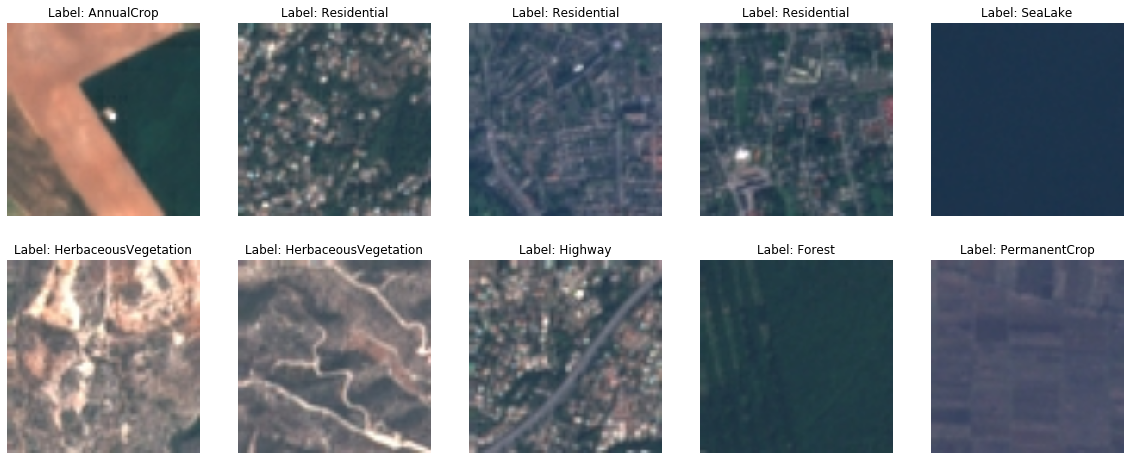

In [130]:
# Define a dictionary to map numerical labels to label names
label_map = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}

# Add a new column to the DataFrame with the label names
df['label_name'] = df['label'].map(label_map)

# Access the image data for the first 10 data point
image_data = df.loc[0:9, 'image']
labels = df.loc[0:9, 'label_name']

# Plot the images with labels
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(image_data[i])
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.show()

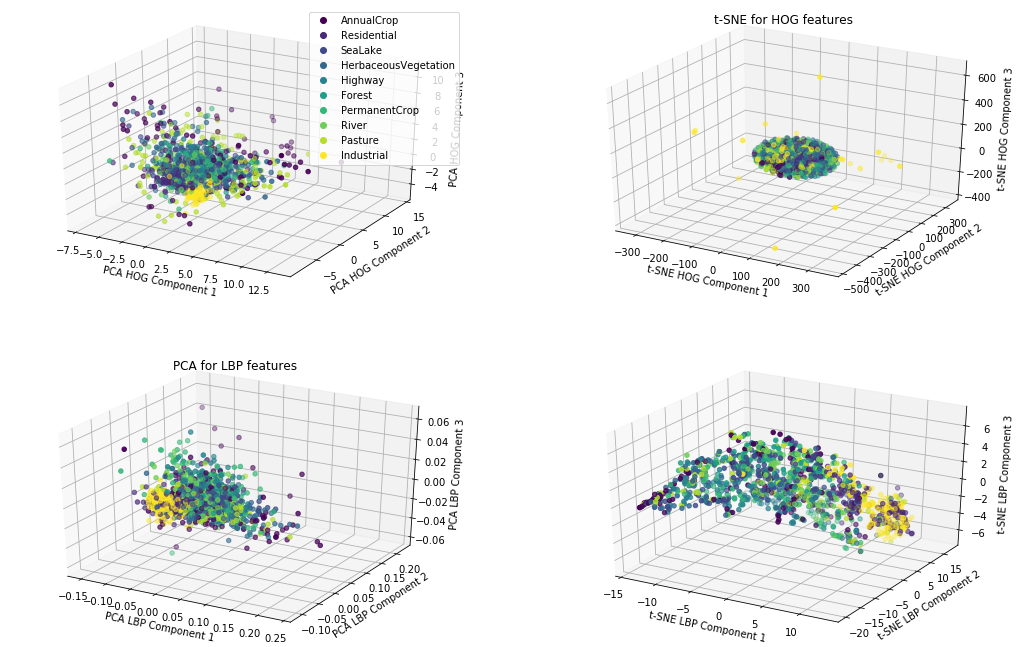

In [135]:
from mpl_toolkits.mplot3d import Axes3D

# Extract the HOG and LBP features from the image data
hog_features = df['hog'].values
lbp_features = df['lbp'].values
#vgg_features = df['vgg'].values

# Pad the features to a fixed length
max_len = max([len(seq) for seq in hog_features] + [len(seq) for seq in lbp_features])
hog_features = pad_sequences(hog_features, maxlen=max_len, dtype='float32', padding='post', truncating='post')
lbp_features = pad_sequences(lbp_features, maxlen=max_len, dtype='float32', padding='post', truncating='post')
#vgg_features = pad_sequences(vgg_features, maxlen=max_len, dtype='float32', padding='post', truncating='post')
# Apply PCA to reduce the dimensions to 3 for visualization
pca = PCA(n_components=3)
pca_hog_features = pca.fit_transform(hog_features)
pca_lbp_features = pca.fit_transform(lbp_features)
#pca_vgg_features = pca.fit_transform(vgg_features)
# Apply t-SNE to reduce the dimensions to 3 for visualization
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200)
tsne_hog_features = tsne.fit_transform(hog_features)
tsne_lbp_features = tsne.fit_transform(lbp_features)
#tsne_vgg_features = tsne.fit_transform(vgg_features)
# Plot the HOG features using a 3D scatter plot

# Plot the HOG features using a 3D scatter plot
fig = plt.figure(figsize=(18, 18))

ax1 = fig.add_subplot(3, 2, 1, projection='3d')
scatter1 = ax1.scatter(pca_hog_features[:, 0], pca_hog_features[:, 1], pca_hog_features[:, 2], c=df['label'].values, label=df['label_name'])
ax1.set_xlabel('PCA HOG Component 1')
ax1.set_ylabel('PCA HOG Component 2')
ax1.set_zlabel('PCA HOG Component 3')
handles, _ = scatter1.legend_elements()
ax1.legend(handles, df['label_name'].unique(), loc='best')


ax2 = fig.add_subplot(3, 2, 2, projection='3d')
ax2.scatter(tsne_hog_features[:, 0], tsne_hog_features[:, 1], tsne_hog_features[:, 2], c=df['label'].values, label=df['label_name'])
ax2.set_xlabel('t-SNE HOG Component 1')
ax2.set_ylabel('t-SNE HOG Component 2')
ax2.set_zlabel('t-SNE HOG Component 3')
ax2.set_title('t-SNE for HOG features')


# Plot the LBP features using a 3D scatter plot
ax3 = fig.add_subplot(3, 2, 3, projection='3d')
ax3.scatter(pca_lbp_features[:, 0], pca_lbp_features[:, 1], pca_lbp_features[:, 2], c=df['label'].values, label=df['label_name'])
ax3.set_xlabel('PCA LBP Component 1')
ax3.set_ylabel('PCA LBP Component 2')
ax3.set_zlabel('PCA LBP Component 3')
ax3.set_title('PCA for LBP features')


ax4 = fig.add_subplot(3, 2, 4, projection='3d')
ax4.scatter(tsne_lbp_features[:, 0], tsne_lbp_features[:, 1], tsne_lbp_features[:, 2], c=df['label'].values, label=df['label_name'])
ax4.set_xlabel('t-SNE LBP Component 1')
ax4.set_ylabel('t-SNE LBP Component 2')
ax4.set_zlabel('t-SNE LBP Component 3')

plt.show()
